In [1]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import numpy as np
import scipy as sc
import time as tm
import pickle
import sympy.physics.mechanics as me
import sys
sys.path.insert(0, "..")
from importlib import reload

In [2]:
import equations as eq
reload (eq);
model_struct = sc.io.loadmat('../das3_eul_abd.mat')
data_struct = sc.io.loadmat('../data_model.mat')
initPos = 'InitPosOptQuat'
start = tm.time()
# eq.create_eoms_eul(model_struct,data_struct,initPos,derive = 'symbolic',gen_matlab_functions = 1)
MM,FO,TE,TE_conoid,q,u,fr,frstar,kindeq,xdot,activations = eq.create_eoms_eul(model_struct,data_struct,initPos,derive = 'numeric',gen_matlab_functions = 0)
time_to_create = tm.time() - start
print(time_to_create)

TE created
equations created
148.2314727306366


In [3]:
import equations as eq
reload (eq);
dict_vals,symlist, value_list = eq.create_parameters_dict(data_struct, initPos)
x0 = data_struct['params'][initPos][0,0]['initCondEul'].item()
x0t = list(x0.T[0])

In [4]:
eoms_implicit = sp.Matrix(kindeq).col_join(fr+frstar+TE)

In [5]:
import trajectory_lib as tr
reload (tr);
num_nodes = 101
file = '../Motion/abduciton/abd_struct.mat'
traj, interval_value, time, _ = tr.exp_trajectory_eul(file,num_nodes)

state_symbols = tuple(q+u)
num_states = len(state_symbols)
specified_symbols = tuple(activations)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [6]:
def obj(free):
    min_traj = 250 * interval_value * np.sum((traj - free[:10*num_nodes])**2)
    min_vel = 20 * interval_value * np.sum((free[10*num_nodes:num_states*num_nodes])**2)
    min_torque = 0.1 * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return min_traj + min_torque + min_vel

def obj_grad(free):
    grad = np.zeros_like(free)
    grad[:10*num_nodes] = 250 * 2.0 * interval_value * (free[:10*num_nodes] - traj)
    grad[10*num_nodes:num_states*num_nodes] = 20 * 2 * interval_value * free[10*num_nodes:num_states*num_nodes]
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = 0.1 * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

In [7]:
instance_constraints = []
# for i in range(3):
instance_constraints.append(state_symbols[9].func(0.0)-x0t[9])

bounds1 = (0.0,1.0)
bounds = (bounds1,)*len(activations)
bndrs = dict(zip(activations,bounds))

In [8]:
start = tm.time()

prob = Problem(obj, obj_grad, eoms_implicit, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds=bndrs,
               integration_method='midpoint'
) #               
time_to_create = tm.time() - start
print(time_to_create)

704.1863307952881


In [9]:
prob.add_option('max_iter',10000)
prob.add_option('limited_memory_max_history', 40)

In [10]:
initial_guess = np.zeros(prob.num_free)
initial_guess[:10*num_nodes] = traj

In [11]:
solution, info = prob.solve(initial_guess)
print(info['status_msg'])
print(info['obj_val'])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:   584001
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    14746
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    12726
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2001
Total number of inequality c

1155.6234640679254


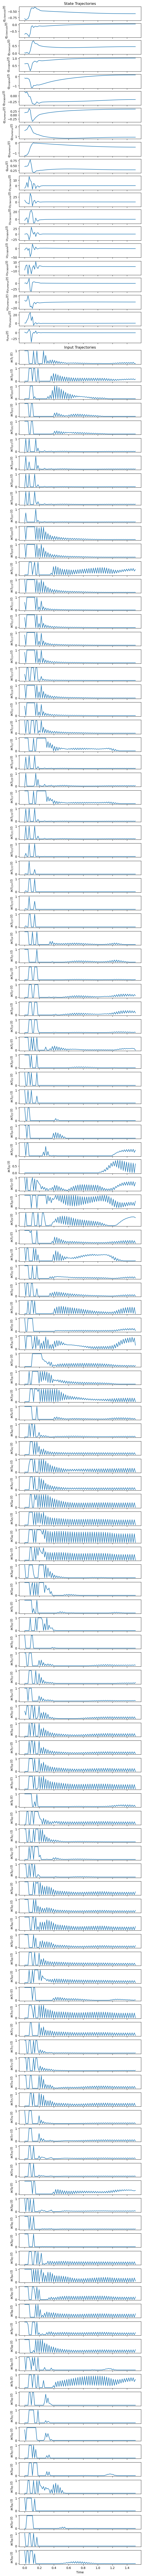

In [12]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(int(num_states+num_inputs), 1, sharex=True,
                         figsize=(6.4, 0.8*(num_states+num_inputs)),
                         layout='compressed')
prob.plot_trajectories(solution, axes=axes)

act_obj = np.sum(solution[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
print(act_obj)

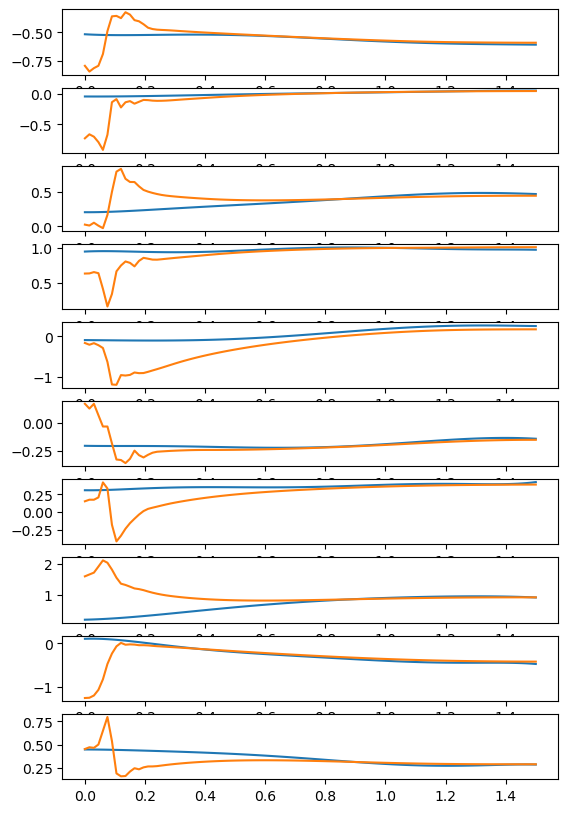

In [13]:
fig, axs = plt.subplots(10)
for j in range(10):
    axs[j].plot(time,traj[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(10)

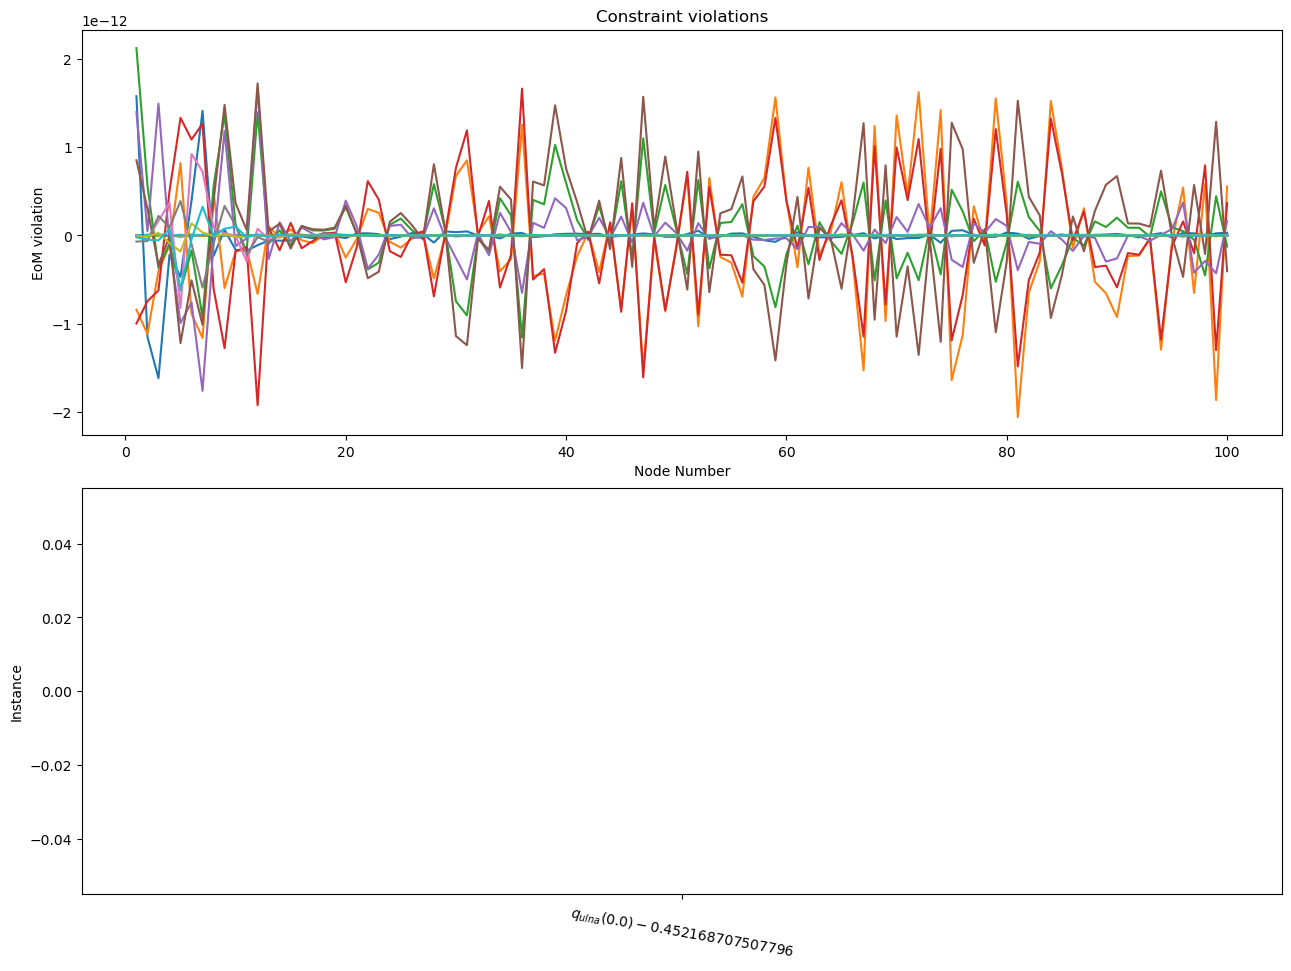

In [14]:
fig, axes = plt.subplots(2, figsize=(12.8, 9.6),
                         layout='constrained')
prob.plot_constraint_violations(solution, axes=axes)

In [15]:
# import equations as eq
# reload (eq);

# sol = eq.sol2mot_quat(solution, num_nodes, len(q), time)


In [16]:
import trajectory_lib as tr
reload (tr);
file_name = '../eul_abd_eulIC.mat'
tr.quat2matfile(solution,activations,len(q),num_states,num_nodes,time,file_name)

Saved to .mat file
